# 쇼핑몰 리뷰 평점 예측 모델
- 데이터 출처: [네이버 쇼핑](https://shopping.naver.com/home)
- [쇼핑몰 리뷰 평점 예측 대회](https://dacon.io/competitions/official/235938/overview/description)

In [263]:
# 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, re
import seaborn as sns

from wordcloud import wordcloud
%matplotlib inline

In [9]:
# 폰트 설치
import matplotlib.font_manager as fm

In [10]:
[f for f in fm.findSystemFonts() if f.lower().find('nanum') > -1]

['C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicExtraBold.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicBold.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquareL.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothic.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquareB.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquareR.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare_acR.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare_0.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumPen.otf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquareEB.ttf',
 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicLight.ttf',
 '

In [11]:
font_path = 'C:\\Users\\Tanks\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothic.ttf'
font = fm.FontProperties(fname=font_path, size=9)

## 데이터 분석

### 데이터 읽어오기

In [6]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')
sample = pd.read_csv('./dataset/sample_submission.csv')

In [7]:
train.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


In [8]:
test.head()

,id,reviews
0,0,채소가 약간 시들어 있어요
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요


### 데이터 확인
#### train 데이터
- id: 샘플 id
- reviews: 쇼핑몰 리뷰 텍스트
- target: 평점

#### test 데이터
- id: 샘플 id
- reviews: 쇼핑몰 리뷰 텍스트

In [15]:
# 데이터 개수
print(train.shape, test.shape)

(25000, 3) (25000, 2)


### 글자 단위 텍스트 길이 분포 확인

In [184]:
train_length = train['reviews'].astype(str).apply(len)
test_length = test['reviews'].astype(str).apply(len)

In [185]:
def textLengthDistribution(data):
    plt.figure(figsize=(12, 8))
    plt.hist(data, bins=140, alpha=0.5, color='r', label='word')
    plt.title('Text Length Distribution')
    plt.xlabel('Length of reviews')
    plt.ylabel('Number of reviews')

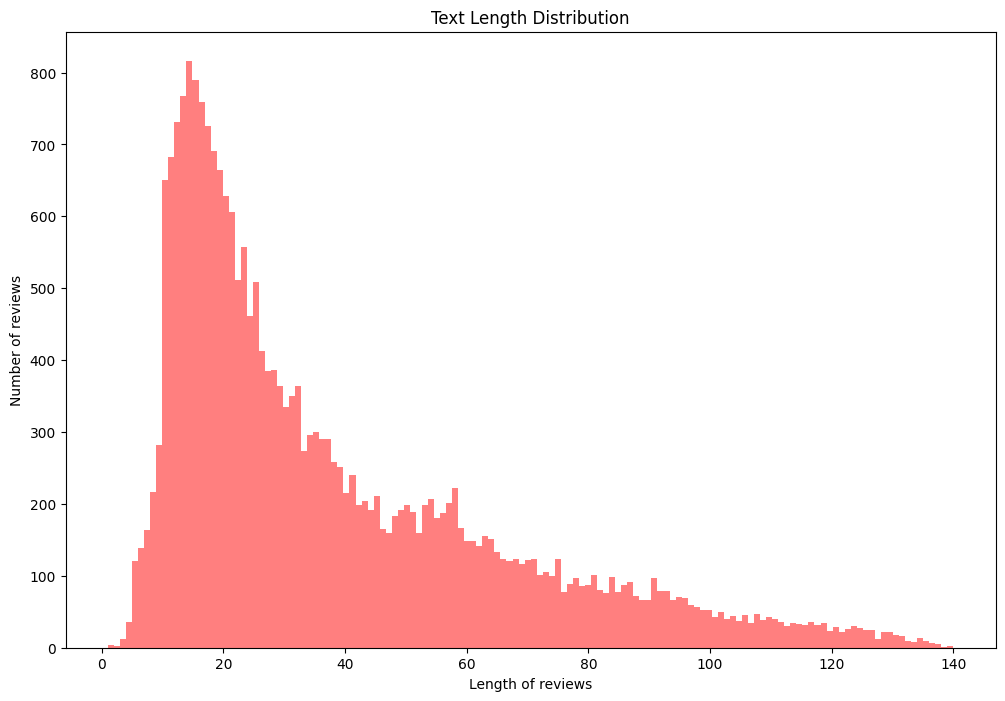

In [186]:
textLengthDistribution(train_length)

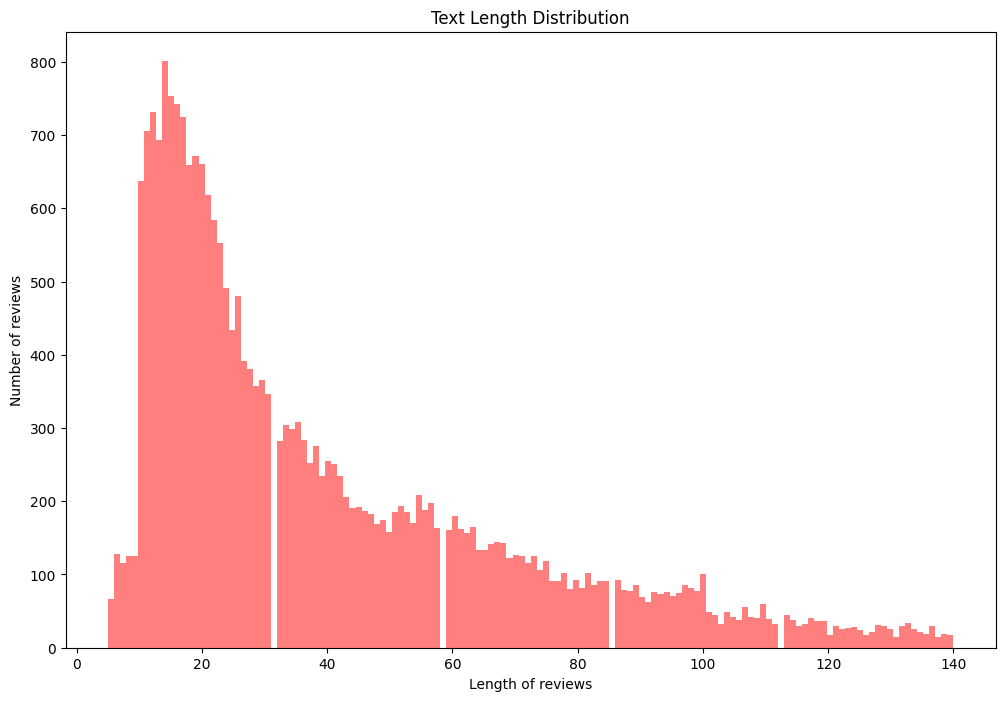

In [187]:
textLengthDistribution(test_length)

### 단어 단위 텍스트 길이 분포

In [188]:
train_word_counts = train['reviews'].astype(str).apply(lambda x: len(x.split(' ')))
test_word_counts = test['reviews'].astype(str).apply(lambda x: len(x.split(' ')))

In [189]:
def textLengthDistributionWords(data):
    plt.figure(figsize=(12,8))
    plt.hist(data, bins=40, alpha=0.5, color='r', label='train')
    plt.title('Text Length Distribution: Words')
    plt.xlabel('Number of words')
    plt.ylabel('Number of counts')

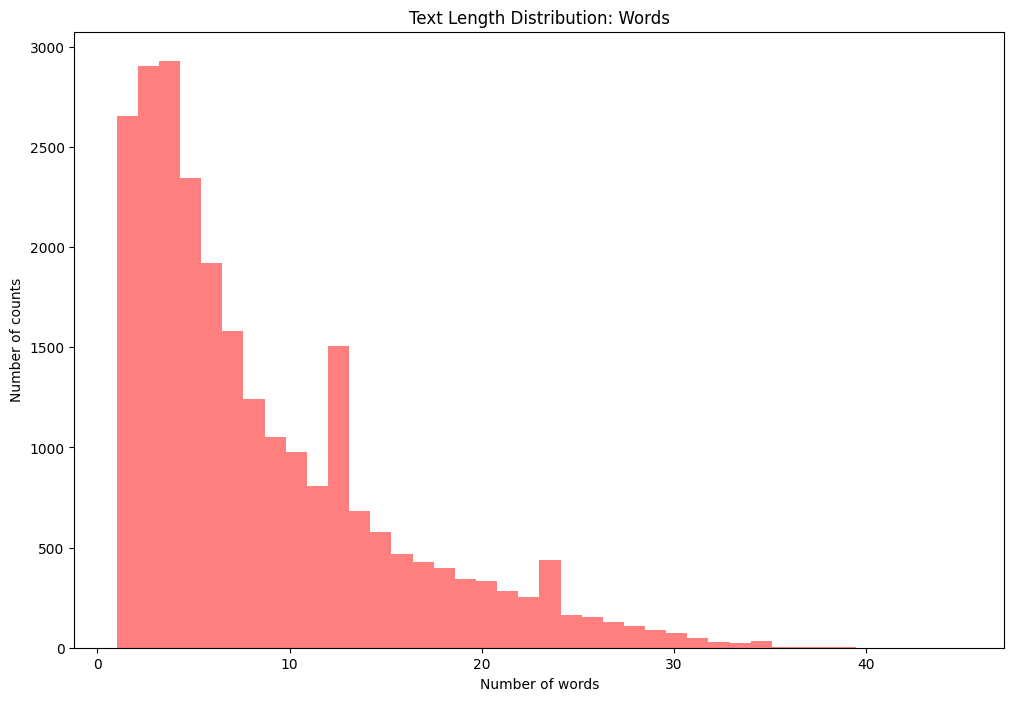

In [190]:
textLengthDistributionWords(train_word_counts)

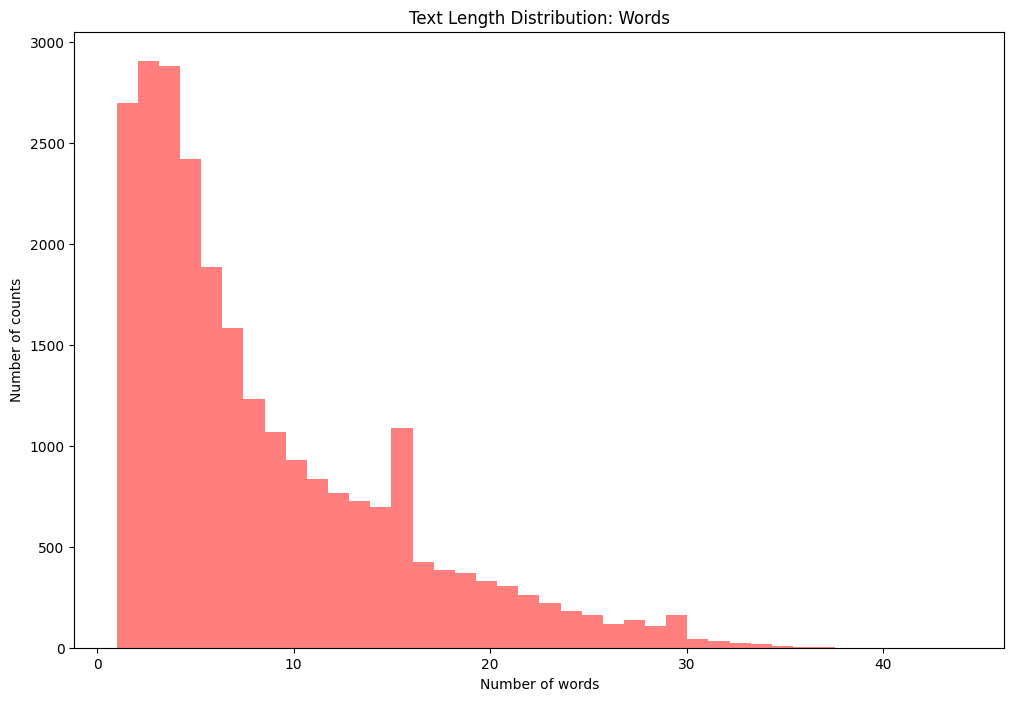

In [191]:
textLengthDistributionWords(test_word_counts)

In [193]:
train_word_counts.describe()

count    25000.000000
mean         8.620000
std          6.619492
min          1.000000
25%          4.000000
50%          6.000000
75%         12.000000
max         45.000000
Name: reviews, dtype: float64

In [194]:
test_word_counts.describe()

count    25000.000000
mean         8.584960
std          6.566365
min          1.000000
25%          4.000000
50%          6.000000
75%         12.000000
max         44.000000
Name: reviews, dtype: float64

`train_word_counts.describe()`와 `test_word_counts.describe()`의 결과로 보았을 때,
`MAX_SEQUENCE_LENGTH`는 10정도가 적합하다고 판단

### 데이터 라벨 분포

<AxesSubplot:xlabel='target', ylabel='count'>

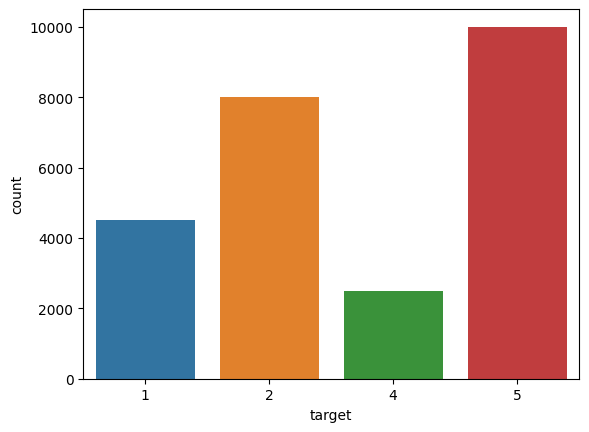

In [31]:
sns.countplot(x='target', data=train)

In [32]:
train['target'].value_counts()

5    10000
2     8000
1     4500
4     2500
Name: target, dtype: int64

## 워드클라우드

In [199]:
train_reviews = [review for review in train['reviews'] if type(review) is str]
test_reviews = [review for review in test['reviews'] if type(review) is str]

In [35]:
train_reviews[:10]

['조아요 처음구입 싸게햇어요',
 '생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 아깝네요',
 '디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져있네요 ㅠ 귀찮아서 그냥쓰려구요 배송기사님은 친절하셨어요',
 '기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘플 써보고 마음에 들어 구매해 사용중 같은 제품을 팔지 않아 할수 없이 플러스를 구매했는데요, 감고나도 머리가 개운하지 않고 간지럽네요. 저랑은 잘 안맞는듯해요.',
 '튼튼하고 손목을 잘 받쳐주네요~',
 '배송은 먼저 구입하신 분들께서 오래걸린다고 하여 참고 기달렸습니다 생각보다 일찍도착해서 좋았구요,하루전날 배송 아저씨가 전화와서 내일1~3시사이에 온다고 하더니 7시에왔어요화나',
 '타이밍이 좋았는지 배송도 빠르고 맛있었어요! 크기가 두가지가 있길래 큰걸 사봤는데 기존에 사먹어봤던거랑 크기 차이는 없네요 그래도 신선하고 맛있어요!',
 '상품 퀄리티가 좋지 않아요',
 '재구매 평소 사용하던 제품이에요. 한번에 쟁여두려 여러개 삽니다 .',
 '두께 때문에 별로네요..']

In [200]:
test_reviews[:10]

['채소가 약간 시들어 있어요',
 '발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리지를 못함 딱딱한 테이프 찾고있는데 또 돈 날렸어요',
 '부들부들 좋네요 입어보고 시원하면 또 살게요',
 '이런   골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임',
 '검수도 없이 보내구 불량 배송비 원 청구하네요 완전별로 별하나도 아까워요',
 '흠 마무리가 넘 안좋아요 가격대비 그냥써봅니다',
 '조금 찌거러져서 왔지만 그냥 써야죠 뭐 신경 좀 써주세요',
 '잘 빠져요 새다리들만 쓸수 있을듯해요그냥 볼때 요거 위에다 다리올려놓고 봅니다',
 '재구매 가격저령하구요 상품질도 좋으네요 또이용하겠습니다',
 '재구매 아이가 너무 좋아합니다 배송도 빠르고 사은품도 너무 좋네요']

In [36]:
wordcloud = wordcloud.WordCloud(font_path=font_path).generate(' '.join(train_reviews))

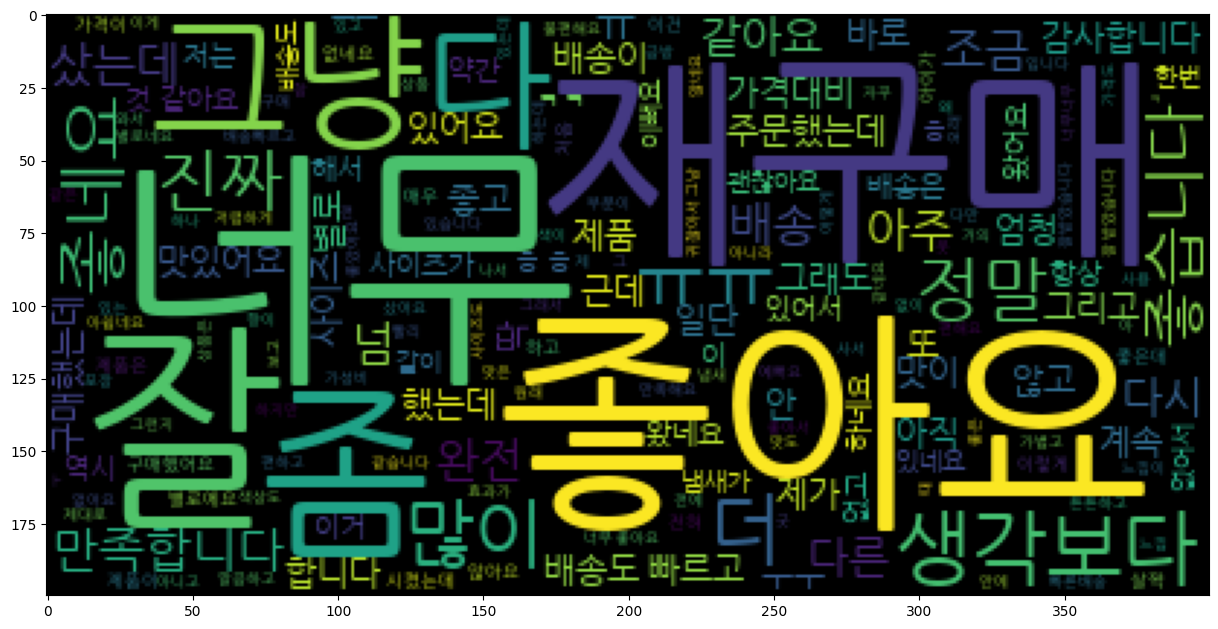

In [37]:
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)

In [264]:
wordcloud_test = wordcloud.WordCloud(font_path=font_path).generate(' '.join(test_reviews))

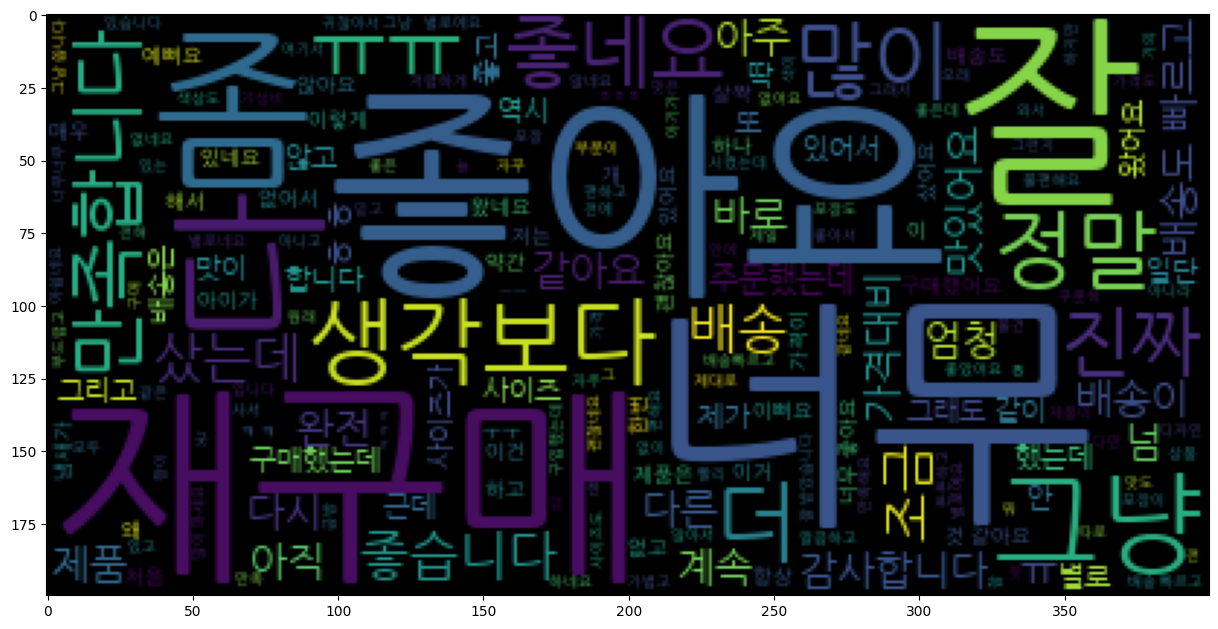

In [265]:
plt.figure(figsize=(15,12))
plt.imshow(wordcloud_test)

## 데이터 전처리

In [38]:
# 전처리를 위한 라이브러리
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm

In [195]:
train['reviews'] = train['reviews'].astype(str).apply(lambda x : re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', '', x))
test['reviews'] = test['reviews'].astype(str).apply(lambda x : re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', '', x))

### 토큰화(Tokenizing), 형태소 분석

In [66]:
okt = Okt()

In [67]:
# 불용어 제거
stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [68]:
def preprocessing(text, okt, remove_stopwords=False, stop_words=[]):
    word_review = okt.morphs(text, stem=True)
    
    if remove_stopwords and len(stop_words) > 0:
        word_review = [word for word in word_review if word not in stop_words]
        
    return word_review

In [69]:
clean_train_reviews = []
for i in tqdm(range(len(train))):
    clean_train_reviews.append(preprocessing(train['reviews'][i], okt, True, stop_words))

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:42<00:00, 586.55it/s]


In [196]:
clean_test_reviews = []
for i in tqdm(range(len(test))):
    clean_test_reviews.append(preprocessing(test['reviews'][i], okt, True, stop_words))

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:09<00:00, 361.71it/s]


In [70]:
train_reviews[0]

'조아요 처음구입 싸게햇어요'

In [71]:
clean_train_reviews[0]

['좋다', '처음', '구입', '싸다', '햇', '어', '요']

In [202]:
test_reviews[0]

'채소가 약간 시들어 있어요'

In [203]:
clean_test_reviews[0]

['채소', '약간', '시들다', '있다']

### 단어 사전 생성 및 인덱싱

In [72]:
tokenizer = Tokenizer()

In [73]:
tokenizer.fit_on_texts(clean_train_reviews)

In [204]:
train_sequences = tokenizer.texts_to_sequences(clean_train_reviews)
test_sequences = tokenizer.texts_to_sequences(clean_test_reviews)

In [75]:
len(train_sequences)

25000

In [76]:
train_sequences[0]

[1, 118, 94, 66, 342, 174, 4]

In [77]:
train_targets = np.array(train['target'])

In [78]:
train_targets

array([2, 1, 2, ..., 4, 2, 5], dtype=int64)

### 패딩 작업

In [217]:
MAX_SEQUENCE_LENGTH = 10

In [218]:
train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [219]:
for i in range(5):
    print(len(train_inputs[i]))

10
10
10
10
10


In [220]:
train_inputs[:5]

array([[   1,  118,   94,   66,  342,  174,    4,    0,    0,    0],
       [ 542,    9,  196,   41,  974, 2199,  123, 1170,    2,  253],
       [1047,  107,   63,  157,   25,  871,    3,  443,  370,  322],
       [2434,   12, 1630,   83, 1343,    8,    9,   55,  161,    4],
       [ 126, 1816,   23,    8, 1570,    0,    0,    0,    0,    0]])

In [221]:
len(tokenizer.index_word)

15413

## 모델링

In [222]:
train.shape, test.shape

((25000, 3), (25000, 2))

In [223]:
# 학습 및 평가 데이터 분리
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(train_inputs, train_targets, test_size=0.1)

In [224]:
train_X.shape, test_X.shape

((22500, 10), (2500, 10))

In [225]:
# 하이퍼 파라미터 설정
VOCAB_SIZE = (len(tokenizer.index_word) + 1)
EMB_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 30

### 모델 설계

In [226]:
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers, utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [227]:
# 클래스 개수
NUM_CLASSES = 4

In [228]:
np.min(train_y), np.max(train_y)

(1, 5)

In [229]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_y_encoded = encoder.fit_transform(train_y)
test_y_encoded = encoder.fit_transform(test_y)

In [230]:
np.min(train_y_encoded), np.max(train_y_encoded)

(0, 3)

In [231]:
train_y_categorical = utils.to_categorical(train_y_encoded, NUM_CLASSES)
test_y_categorical = utils.to_categorical(test_y_encoded, NUM_CLASSES)

In [232]:
np.min(train_y_categorical), np.max(train_y_categorical)

(0.0, 1.0)

In [233]:
input_x = layers.Input((MAX_SEQUENCE_LENGTH,))

emb = layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(input_x)

drob_1 = layers.Dropout(0.2)(emb)
rnn_1 = layers.GRU(units=64, activation='tanh', return_sequences=True)(drob_1)

drob_2 = layers.Dropout(0.2)(rnn_1)
rnn_2 = layers.GRU(units=32, activation='tanh', return_sequences=True)(drob_2)

drob_3 = layers.Dropout(0.2)(rnn_2)
rnn_3 = layers.GRU(units=16, activation='tanh', return_sequences=True)(drob_3)

rnn_4 = layers.GRU(units=8, activation='tanh', return_sequences=False)(rnn_3)
drob_4 = layers.Dropout(0.2)(rnn_4)

output = layers.Dense(units=NUM_CLASSES, activation='softmax')(drob_4)

model = models.Model(input_x, output)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 10)]              0         
                                                                 
 embedding_10 (Embedding)    (None, 10, 128)           1972992   
                                                                 
 dropout_40 (Dropout)        (None, 10, 128)           0         
                                                                 
 gru_37 (GRU)                (None, 10, 64)            37248     
                                                                 
 dropout_41 (Dropout)        (None, 10, 64)            0         
                                                                 
 gru_38 (GRU)                (None, 10, 32)            9408      
                                                                 
 dropout_42 (Dropout)        (None, 10, 32)            0  

In [234]:
# EarlyStopping, ModelCheckpoint 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [235]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [236]:
history = model.fit(train_X, train_y_categorical, epochs=EPOCHS, callbacks=[es, mc], batch_size=BATCH_SIZE, validation_split=0.1)

Epoch 1/30
1263/1266 [============================>.] - ETA: 0s - loss: 1.0024 - accuracy: 0.5855
Epoch 00001: val_accuracy improved from -inf to 0.64489, saving model to best_model.h5
1266/1266 [==============================] - 15s 10ms/step - loss: 1.0019 - accuracy: 0.5857 - val_loss: 0.8892 - val_accuracy: 0.6449
Epoch 2/30
1266/1266 [==============================] - ETA: 0s - loss: 0.8371 - accuracy: 0.6592
Epoch 00002: val_accuracy did not improve from 0.64489
1266/1266 [==============================] - 12s 10ms/step - loss: 0.8371 - accuracy: 0.6592 - val_loss: 0.8860 - val_accuracy: 0.6387
Epoch 3/30
1261/1266 [============================>.] - ETA: 0s - loss: 0.7268 - accuracy: 0.7205
Epoch 00003: val_accuracy did not improve from 0.64489
1266/1266 [==============================] - 12s 10ms/step - loss: 0.7266 - accuracy: 0.7207 - val_loss: 0.9463 - val_accuracy: 0.6271
Epoch 4/30
1261/1266 [============================>.] - ETA: 0s - loss: 0.6332 - accuracy: 0.7615
Epoch 

## 예측 결과

In [266]:
class_map = [1, 2, 4, 5] # 데이콘 대회안내에도 적혀있지만 1, 2, 4, 5 총 4개의 평점만 존재

In [237]:
# 모델 예측
y_pred = model.predict(test_X)

In [238]:
y_pred[0]

array([0.00304467, 0.00772238, 0.05433584, 0.9348972 ], dtype=float32)

In [239]:
y_pred.shape

(2500, 4)

In [267]:
y_pred_class = [class_map[i] for i in np.argmax(y_pred, axis=1)]

In [269]:
y_pred_class[:20]

[5, 5, 1, 5, 5, 2, 5, 5, 2, 5, 1, 2, 5, 1, 5, 5, 5, 2, 4, 5]

In [270]:
import random

for i in range(10):
    rand_num = random.randint(0, 2500)
    
    print('review: ', train['reviews'][rand_num])
    print('실제 평점: ', test_y[rand_num])
    print('예측 평점: ', y_pred_class[rand_num])
    print('')

review:  배송 빨라요 제품도 안터진거 오고 좋아용 그런데 거품 잠깐 나고 몇 초 지나니 거품 사라지고 세정력 없네요 네스푼 넣어도 다른제품 반스푼 넣은 만큼도 세정력이 떨어집니다 저렴하고 양 많아서 잘 산줄 알았는데 욕만 먹고있어요 다신안사
실제 평점:  5
예측 평점:  5

review:  바를깨 쿨링감이 있어서 좋아요 시원해요
실제 평점:  1
예측 평점:  1

review:  구멍난걸 보내면 어떡합니까ㅡㅡ
실제 평점:  5
예측 평점:  5

review:  눈에 너무 잘띄는 곳에 스크레치나서 왔어요ㅠ 톡톡문의 답이 없으셔서 그냥 사용하기로 했는데 넘 거슬리고 속상해요ㅠ
실제 평점:  4
예측 평점:  2

review:  핏이 좋아서 가성비 좋은 상품같아요 다만 얇아서 쉽게 뜯어지진 않을까 걱정은 되지만 얆아서 여름에 시원하게 입을수 있을것 같아요
실제 평점:  2
예측 평점:  1

review:  산사람으로써 완전 진짜별로 역시 보고 사야됨 수납공간도 너무작고 책 세권 넣으면 꽉차겠음 차라리 딴거 살껄 완전 후회중
실제 평점:  2
예측 평점:  2

review:  뚜껑이 안열려 엄청 고생했습니다 새침대에 있는 수납장이랑 침대프레임위에 뿌렸는데 침대가 편백나무액으로 다 얼룩지고 부풀어 올라서 이틀뿌리고 중단했습니다ㅜㅜ
실제 평점:  1
예측 평점:  1

review:  배송은 빠르나 제품이 누락 및 오배송됨 환불기간 오래걸림
실제 평점:  2
예측 평점:  5

review:  써봐야알겟지만 닦이긴 잘 닦입니다 다만 중국산이라 내구성이 별로 좋지않을까 걱정이됩니다 배송은 빨라요
실제 평점:  5
예측 평점:  5

review:  점찍어 놓은거 처럼 약간 녹이 나있는데 반품하기 귀찮아서 그냥씁니다
실제 평점:  1
예측 평점:  2



## sample_submission.csv 파일 작성

In [243]:
# best_model.h5 모델 로드
loaded_model = load_model('best_model.h5')

In [246]:
y_test_pred = loaded_model(test_inputs)

In [247]:
y_test_pred[0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.12510216, 0.34164223, 0.13224299, 0.4010126 ], dtype=float32)>

In [271]:
y_test_pred_class = [class_map[i] for i in np.argmax(y_test_pred, axis=1)]

In [272]:
y_test_pred_class[:20]

[5, 2, 5, 2, 1, 2, 2, 2, 5, 5, 2, 5, 5, 2, 2, 5, 2, 2, 5, 5]

In [254]:
sample.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [273]:
sample['target'] = y_test_pred_class
sample.to_csv('submission.csv', index=False)

### 데이콘 제출 결과

![](https://github.com/SPAI-Lab/GenerativeAI_Study/assets/59556524/e9275c78-d89c-40f3-9eeb-d1a6324dcd6d)